In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.insert(0, "../code-previous")
sys.path.insert(0, "..")

import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()

In [10]:
import pandas as pd
import numpy as np
import nltk
stopwords = nltk.corpus.stopwords.words('english')

from sklearn.model_selection import train_test_split

from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
path2rawdata = '/mnt/disks/vault/wos2017-parsed/'

In [4]:
raw_data_path = "/mnt/disks/vault/analysis-data/raw_data_full/raw_data_full.pql"
data = pd.read_pickle(raw_data_path)

data = data[data.Journal == "APPLIED PHYSICS LETTERS"]

In [5]:
# filtering the data on which the model could be fit well
data = data[data.PubYear_x.isin([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
len(data)

41100

In [6]:
# what is the average number of words per year
# New fields to dataframe 
data['log_c5'] = data['c5'].progress_apply(lambda x: np.log(x+1))
data['character_count'] = data['Title'].progress_apply(lambda x: len(x))
data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
data['title_without_punct'] = data['Title'].progress_apply(lambda x: 
                                                           str.lower(''.join(ch for ch in str(x) if category(ch)[0] != 'P')))
data["title_without_stopwords"] = data['title_without_punct'].progress_apply(lambda x: 
                                                                            " ".join([word for word in x.split() if word not in stopwords]))


data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
data["cleaned_title_word_count"] = data["title_without_stopwords"].progress_apply(lambda x: len(x.split()))

Progress: 100%|██████████| 41100/41100 [00:00<00:00, 534471.90it/s]


In [7]:
def get_grouped_data_for_year(year):
    tmp = data[data.PubYear_x == year]
    tmp = tmp.groupby('word_count')['c5'].mean().reset_index(name="avg_c5")
    tmp['avg_log_c5'] = tmp['avg_c5'].apply(lambda x: np.log(x))
    return tmp
    
grouped_avgs = [get_grouped_data_for_year(year) for year in range(2002, 2011)]

In [8]:
x02 = list(grouped_avgs[0]["word_count"])
y02 = list(grouped_avgs[0]["avg_log_c5"])
x03 = list(grouped_avgs[1]["word_count"])
y03 = list(grouped_avgs[1]["avg_log_c5"])
x04 = list(grouped_avgs[2]["word_count"])
y04 = list(grouped_avgs[2]["avg_log_c5"])
x05 = list(grouped_avgs[3]["word_count"])
y05 = list(grouped_avgs[3]["avg_log_c5"])
x06 = list(grouped_avgs[4]["word_count"])
y06 = list(grouped_avgs[4]["avg_log_c5"])
x07 = list(grouped_avgs[5]["word_count"])
y07 = list(grouped_avgs[5]["avg_log_c5"])
x08 = list(grouped_avgs[6]["word_count"])
y08 = list(grouped_avgs[6]["avg_log_c5"])
x09 = list(grouped_avgs[7]["word_count"])
y09 = list(grouped_avgs[7]["avg_log_c5"])
x10 = list(grouped_avgs[8]["word_count"])
y10 = list(grouped_avgs[8]["avg_log_c5"])

Text(0,0.5,'Average logC5')

<Figure size 432x288 with 0 Axes>

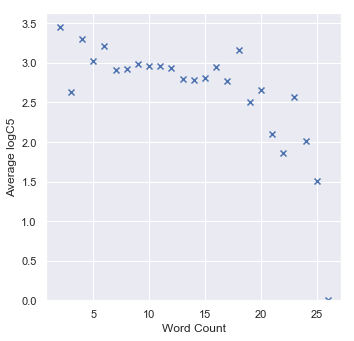

In [16]:
X_years = [x02, x03, x04, x05, x06, x07, x08, x09, x10]
y_years = [y02, y03, y04, y05, y06, y07, y08, y09, y10] 


def get_data_for_year(idx):
    X = pd.DataFrame(X_years[idx], columns=["word_count"])
    y = pd.DataFrame(y_years[idx], columns=["avg_log_c5"])
    
    df = pd.concat([X, y], axis=1)
    df = df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]
    
    return df

# Average character, word and cleaned title word counts over the years
f1 = plt.figure()
f1 = plt.figure(figsize=(18,18))


ax1 = f1.add_subplot(331)

tmp = get_data_for_year(0)
# set weights
weights = len(tmp)
ax1.scatter(tmp['word_count'], 
            tmp['avg_log_c5'], 
            marker='x')
ax1.set_ylim(ymin=0)
ax1.set_xlabel("Word Count")
ax1.set_ylabel("Average logC5")

In [12]:
mod_wls = sm.WLS(y_, X, weights=1./(w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

NameError: name 'w' is not defined